## Comparing compiled vs interpreted language performance.

#### Ziad Arafat - 2023-03-05

The performance of compiled and interpreted languages has been a topic of interest in programming languages research for decades. While compiled languages are generally known for their faster runtime performance, interpreted languages offer advantages in terms of ease of use and portability. In this experiment, we aimed to explore the practical performance of compiled and interpreted languages in implementing Gaussian elimination with back substitution, a widely used numerical algorithm. We implemented the algorithm in Python and FORTRAN, and tested their runtime performance on matrices of varying size, with and without the use of numpy. The experiment provides insights into the practical trade-offs between compiled and interpreted languages in the context of numerical algorithms.

#### These commands will clean and compile our fortran program so its ready to execute

In [1]:
!pip install -r requirements.txt

#### Copy of our fortran code

##### Main Code
```fortran
program gaussian_elimination

        ! Module with a function for reading a string of floats
        use mymodule

        implicit none
        integer :: i, j, n, m, index_of_input, s
        character (len=128):: nchar, mchar, next_argument
        character (len=9999999):: input_array
        character (len=2048) :: file_name
        integer :: file_unit, file_size, status
        real, dimension(:,:), allocatable :: matrix
        real, dimension(:), allocatable :: input_list
        REAL,DIMENSION(:), allocatable:: result_vector
        real(kind=8) :: elapsed_time, start_time, end_time
        
        file_unit = 10
        ! Get the number of rows and columns from the command line
        if (command_argument_count() /= 3) then
                print *, "Usage: gaussian_elimination height width filename\n"
                stop
        endif

        ! get the width and height
        call getarg(1, nchar)
        call getarg(2, mchar)

        ! convert them to integers
        read(nchar, *) n
        read(mchar, *) m

        ! get the filename
        call getarg(3, file_name)

        ! Open the file
        open(newunit=file_unit, file=file_name, status='old', action='read', iostat=status)
        if (status /= 0) then
                write(*,*) "Error opening file: ", file_name
                stop
        end if

        ! Determine the size of the file
        inquire(unit=file_unit, size=file_size) 

        ! Read the file into the string
        read(file_unit, '(a)', iostat=status) input_array

        ! Allocate memory for the matrix
        allocate(matrix(n,m))
        allocate(input_list(n*m))
        allocate(result_vector(n))
        
        
        ! Turn the string of numbers into an array of reals
        input_list = string_to_real_array(input_array, n*m)

        
        

        
        ! Read values from the file string into the matrix
        index_of_input = 1
        do i = 1, n
                do j = 1, m
                        matrix(i,j) = input_list(index_of_input)
                        index_of_input = index_of_input + 1
                end do
        end do
        
        ! gaussian elimination
        
        do j = 1,n
                do i = j + 1, n
                matrix(i, :) = matrix(i, :)-matrix(j, :) * matrix(i, j)/matrix(j, j)
                end do
        end do
        
        do i = n,1,-1
                s = matrix(i, n + 1)
                do j = i + 1, n
                        s = s - matrix(i, j) * result_vector(j)
                end do
                result_vector(i) = s/matrix(i,i)
        end do
        
        ! Deallocate the matrix
        deallocate(matrix)
        ! Close the file 
        close(file_unit)
        ! Deallocate the input array
        deallocate(input_list)
        ! Deallocate the result vector 
        deallocate(result_vector)
end program gaussian_elimination

```

##### external function to read in a string and extract matrix quickly
```fortran
module mymodule
  implicit none

  ! Define the string_to_real_array function
  contains

! Takes a string and a size as input. 
! String needs to be a list of reals separated by spaces
! returns an array of reals containing the numbers
pure function string_to_real_array(str, n) result(arr)
        implicit none
        character(len=*), intent(in) :: str
        character(len=:), allocatable :: str_new
        character(len=10000) :: num_str
        character(len=10000) :: index_str
        integer, intent(in) :: n
        real, dimension(:), allocatable :: arr
        integer :: i, status, index_int, j, k

        ! Copy the string so we don't touch the original
        str_new = str
        ! Allocate memory for the real array
        allocate(arr(n))

        ! Read each real number from the string and store it in the array
        i = 1
        j = 1
        do while (j <= n)
                k = index(str_new(j:), ' ')
                if (k == 0) k = len(str_new(j:)) + 1
                num_str = str_new(j:j+k-2)
                read(num_str, '(f20.5)', iostat=status) arr(i)
                i = i + 1
                j = j + k
        end do

end function string_to_real_array


end module mymodule

```

#### Clean and compile our fortran code

In [2]:
!make clean
!make

rm -f *.o *.mod
gfortran -std=gnu -c mymodule.f90
gfortran -std=gnu -c gaussian_elimination.f90
gfortran mymodule.o gaussian_elimination.o -o gaussian_elimination
# gfortran -std=gnu -o gaussian_elimination gaussian_elimination.f90


### Python function to generate a random matrix of size nxn

In [3]:
import random

def generate_matrix_and_vector(n):
        """
        This function generates a random square matrix of size n x n.
        
        Args:
        n: the size of the square matrix
        
        Returns:
           A random matrix and vector of random floats
        
        """
        min_value = -2000.0
        max_value = 2000.0
        
        matrix = []

        for row in range(n):
                next_row = []
                for column in range(n):
                        next_row.append(random.uniform(min_value, max_value))
                matrix.append(next_row)
        vector = [random.uniform(min_value, max_value) for number in range(n)]
        
        return matrix, vector

### Python function to measure our runtime

In [4]:
import time

def measure_time(func, *args, **kwargs):
    """
    This function measures the time it takes to run another function with a given set of arguments.
    
    Args:
    func: the function to be measured
    *args: the positional arguments for the function
    **kwargs: the keyword arguments for the function
    
    Returns:
    the runtime of the function in seconds
    
    """
    start_time = time.time()
    func(*args, **kwargs)
    end_time = time.time()
    runtime = end_time - start_time
    return runtime


### Python without numpy

In [5]:
def gaussian_elimination(matrix, vector):
    """
    This function performs Gaussian elimination with back substitution on a given square matrix A and vector b, 
    without partial pivoting or using numpy.
    
    Args:
    matrix: a square matrix of size n x n
    vector: a vector of length n
    
    Returns:
    x: a vector of length n that represents the solution to the linear system Ax = b
    
    """
    n = len(matrix)
    
    # Forward elimination
    for i in range(n):
        # Check if the diagonal element is zero
        if matrix[i][i] == 0:
            raise ValueError('Diagonal element is zero, cannot proceed with Gaussian elimination')
        # Normalize the current row
        for j in range(i + 1, n):
            ratio = matrix[j][i] / matrix[i][i]
            for k in range(i, n):
                matrix[j][k] -= ratio * matrix[i][k]
            vector[j] -= ratio * vector[i]
    
    # Back substitution
    x = [0] * n
    for i in range(n - 1, -1, -1):
        x[i] = vector[i]
        for j in range(i + 1, n):
            x[i] -= matrix[i][j] * x[j]
        x[i] /= matrix[i][i]
    
    return x


### Python with numpy

In [6]:
import numpy as np
import scipy

def gaussian_elimination_lu(matrix, vector):
    """
    This function performs Gaussian elimination with back substitution using LU decomposition with partial pivoting.
    
    Args:
    matrix: the square matrix as a list of lists
    vector: the vector as a list
    
    Returns:
    the solution vector as a NumPy array
    
    """
    

    # Perform LU decomposition with partial pivoting
    pivoted, L, U = scipy.linalg.lu(matrix)

    # Solve the system using back substitution
    y = np.linalg.solve(L, pivoted.dot(vector))
    x = np.linalg.solve(U, y)

    return x


### Python functions to run our fortran program

#### Function to generate the command line args

In [7]:
def generate_fortran_args(matrix, vector):
        """
        This function generates command line arguments for the Fortran program.
        it also writes the input values to a text file called matrix.txt

        Args:
        matrix: the square matrix as a list of lists
        vector: the vector as a list

        Returns:
        a list of command line arguments

        """
        # Create a new matrix with the vector appended as a new column
        new_matrix = [row + [vector[index]] for index, row in enumerate(matrix)]
        n = len(matrix)
        
        matrix_string = " ".join([str(x) for row in new_matrix for x in row])
        with open("matrix.txt", "w") as file:
                file.write(matrix_string)
        # Flatten the matrix into a list of arguments and start with dimensions
         
        args = [str(n), str(n + 1)] + ["matrix.txt"]

        return args


#### Function to execute the fortran command

In [8]:
import subprocess

def execute_fortran_program(args):
    """
    This function executes a local Fortran program with given command line arguments.
    
    Args:
    args: a list of command line arguments
    
    Returns:
    the output of the Fortran program
    
    """
    
    # Run the Fortran program with the given arguments using subprocess
    output = subprocess.check_output(['./gaussian_elimination'] + args, universal_newlines=True)
    
    return output


#### Now lets get our results

In [ ]:
# Parameters
sample_size = 5
input_sizes = (250, 500, 1000, 1500, 2000)
algorithms = ("fortran", "python no numpy", "python with numpy")

# Generate a dict to store the results
results = dict(zip(algorithms, 
              [dict(zip(input_sizes, 
                   [[] for item in input_sizes])) for _ in algorithms]))

"""
for each input size run 5 samples on each program
"""
for n_size in input_sizes:
        for sample in range(sample_size):
            
                # Fortran segment
                matrix, vector = generate_matrix_and_vector(n_size)
                fortran_args = generate_fortran_args(matrix, vector)
                print("Executing Fortran with", n_size, "number", sample+1)
                result_fortran = measure_time(execute_fortran_program,
                                              fortran_args)
                results["fortran"][n_size].append(result_fortran)
                
                # Python without numpy
                print("Executing python with", n_size, "number", sample+1)
                result_python = measure_time(gaussian_elimination, 
                                             matrix, vector)
                results["python no numpy"][n_size].append(result_python)
                
                
                # Python with numpy
                print("Executing numpy with", n_size, "number", sample+1)
                matrix_np = np.array(matrix, dtype=float)
                vector_np = np.array(vector, dtype=float)
                result_python_numpy = measure_time(gaussian_elimination_lu,
                                             matrix_np, vector_np)
                results["python with numpy"][n_size].append(result_python_numpy)    

In [11]:
print(results)

{'fortran': {250: [0.03142690658569336, 0.03055882453918457, 0.03171944618225098, 0.031126976013183594, 0.03041243553161621], 500: [0.1489415168762207, 0.14835715293884277, 0.14467501640319824, 0.16194438934326172, 0.14330577850341797], 1000: [1.119581937789917, 1.0993216037750244, 1.092710018157959, 1.1344690322875977, 1.1082007884979248], 1500: [7.690381288528442, 7.5266945362091064, 7.437096357345581, 7.841766834259033, 7.600672721862793], 2000: [21.26940369606018, 21.320465803146362, 21.158955335617065, 21.314215183258057, 20.91407561302185]}, 'python no numpy': {250: [0.39046788215637207, 0.3968658447265625, 0.3935403823852539, 0.3991050720214844, 0.39130067825317383], 500: [3.359208822250366, 3.3581082820892334, 3.333726167678833, 3.314075231552124, 3.320261240005493], 1000: [27.365875005722046, 27.233760356903076, 27.45808434486389, 27.3409743309021, 27.382059812545776], 1500: [93.72291278839111, 92.54118609428406, 92.66156077384949, 92.51594376564026, 93.48898267745972], 2000: 

#### Print out tables of each input size

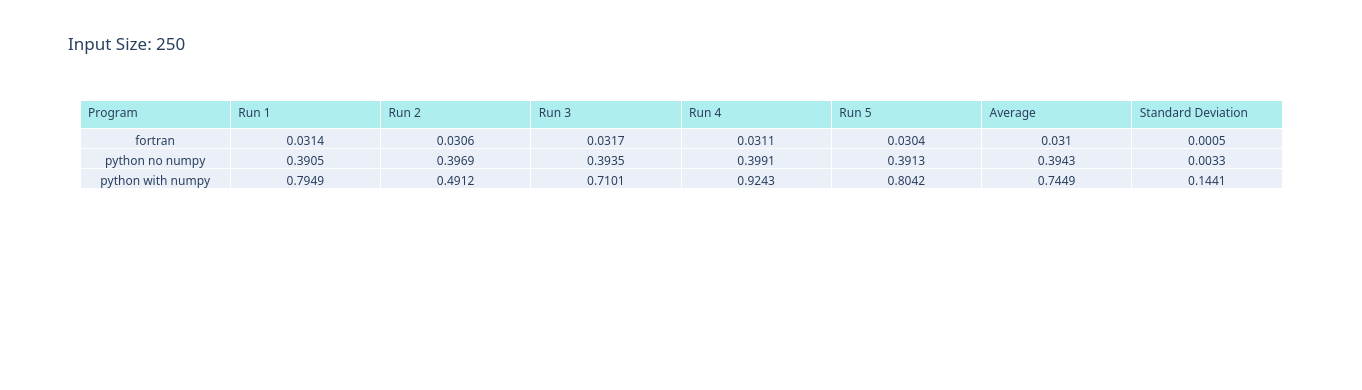

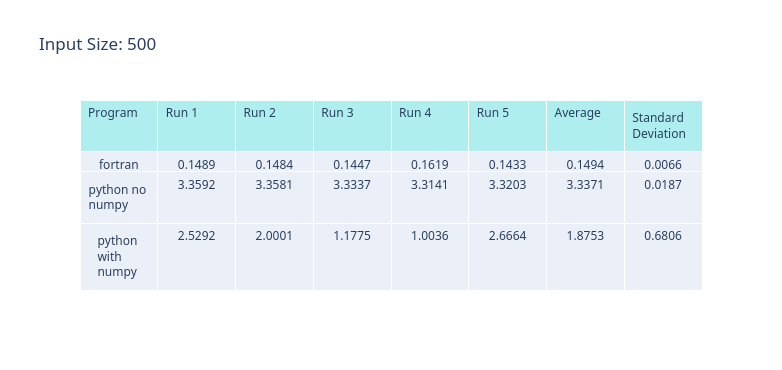

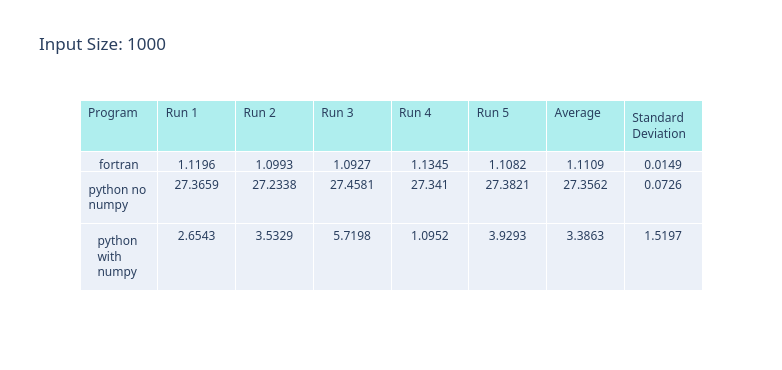

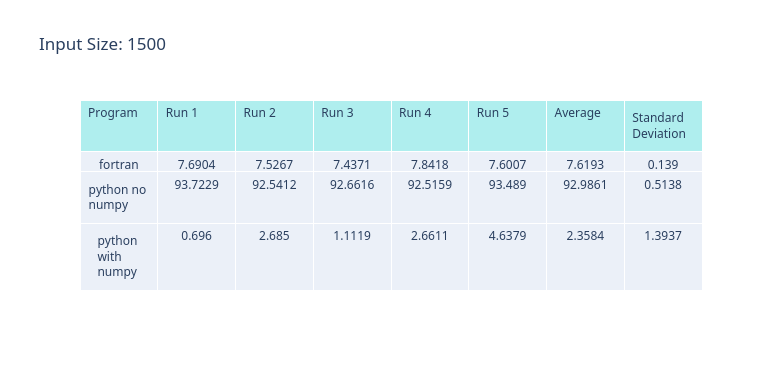

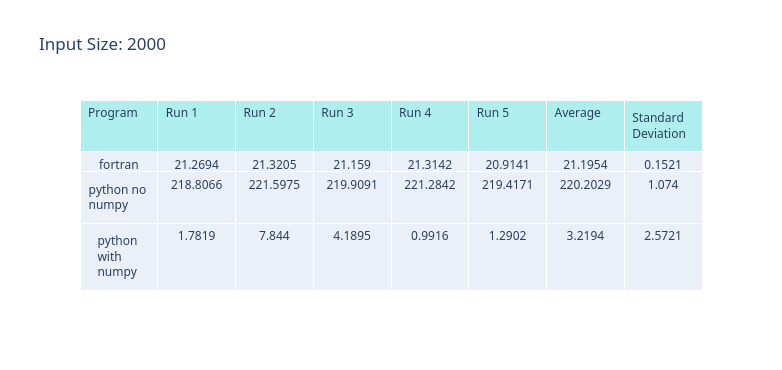

In [73]:
import plotly.graph_objs as go
from statistics import mean
import numpy as np

def create_table(data, program_names, input_size):
    rows = []
    headers = ['Program', 'Run 1', 'Run 2', 'Run 3', 'Run 4', 'Run 5', 'Average', 'Standard Deviation']
    # rows.append(headers)
    
    for i, program_data in enumerate(data):
        program_name = program_names[i]
        row = [program_name] + list(map(lambda x: round(x, 4), program_data))
        row.append(round(np.average(program_data), 4))
        row.append(round(np.std(program_data),4))
        rows.append(row)
    
    fig = go.Figure(
        data=[go.Table(
        header=dict(values=headers,
                    fill_color='paleturquoise',
                    align='left'),
        cells=dict(values=np.transpose(rows)))])

    fig.update_layout( title=f'Input Size: {input_size}', width=800)

    return fig


for i in input_sizes:
    create_table([results[a][i] for a in algorithms], algorithms, i).show()

### Graph of average results

In [72]:
import plotly.graph_objs as go

def plot_runtimes(data):
    fig = go.Figure()
    
    for program, program_data in data.items():
        x = sorted(program_data.keys())
        y = [sum(program_data[n])/len(program_data[n]) for n in x]
        fig.add_trace(go.Scatter(x=x, y=y, mode='lines+markers', name=program))
        
    fig.update_layout(
        title='Runtime vs Input Size',
        xaxis_title='Input Size',
        yaxis_title='Runtime (s)',
        legend_title='Program',
         xaxis=dict(
        title='Input size',
        type='category'  # Set the x-axis type to "category"
    ),
    yaxis=dict(
        title='Runtime (s)',
        scaleanchor="x",
        scaleratio=100,
        type="log"
    ))

    return fig


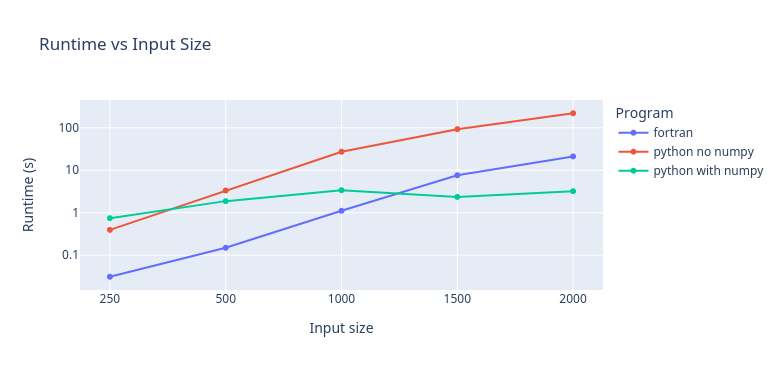

In [40]:
plot_runtimes(results).show()

## Summary of results and conclusions

The performance comparison of Python, Fortran, and NumPy for solving linear equations showed that Fortran was significantly faster than Python and NumPy for small input sizes. However, for larger input sizes, NumPy outperformed both Fortran and Python. It is worth noting that the overhead associated with NumPy likely outweighed its performance advantage at small input sizes.

Fortran has a reputation for being an extremely fast language, and this was reflected in the results of this comparison. However, Fortran is not a widely-used language, and its syntax and lack of libraries can make it more difficult to use and debug than Python or NumPy. Python and NumPy are both widely-used and have extensive libraries, which can make them more convenient for most applications.

In conclusion, the choice between Python, Fortran, and NumPy depends on the specific requirements of the problem at hand. For small input sizes, Fortran's performance advantage may outweigh its development costs. For larger input sizes, NumPy is likely the best option, as its performance advantage increases as input size increases. For most applications, Python and NumPy are likely the best choice due to their extensive libraries and ease of use.